# Notebook Imports

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Sklearn
import sklearn
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# NLTK
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer

# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from torchtext.vocab import build_vocab_from_iterator

%matplotlib inline

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

! unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/w

## Constants

In [3]:
FILE = '/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv'

# Step 1: Data Collection and Loading

* Large Movie Review Dataset [Link](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews/data)

In [4]:
df = pd.read_csv(FILE)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [6]:
print(f"The empty row in the data: \n{df.isnull().sum()}")

The empty row in the data: 
review       0
sentiment    0
dtype: int64


In [7]:
print(f"\nThe shape of the data: {df.shape}\n")
print(f"The types of the data: \n{df.dtypes}\n")


The shape of the data: (50000, 2)

The types of the data: 
review       object
sentiment    object
dtype: object



# Step 2: Data Preprocessing

* **Text Cleaning:** Remove any HTML tags, special characters, numbers, and other non-alphabetic characters.
* **Tokenization:** Split the reviews into individual words (tokens).
* **Stop Words Removal:** Remove common words that do not contribute to the sentiment, such as 'and', 'the', 'is', etc.
* **Lemmatization:** Reduce words to their base or root form.

### Text Cleaning

In [8]:
df.nunique()

review       49582
sentiment        2
dtype: int64

In [9]:
df = df.drop_duplicates()
print(df.shape)
df.head()

(49582, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [10]:
# remove html tags from text
def remove_html_tags(text):
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

### Tokenization, Stop Words Removal, Lemmatization

In [11]:
def clean_review(text, wl=WordNetLemmatizer(), 
               stop_words=set(stopwords.words('english'))):
    # Remove HTML tags
    cleaned_text = remove_html_tags(text)
    
    # Converts to lower case and splits up the words
    words = word_tokenize(cleaned_text.lower())
    
    filtered_words = []
    
    for word in words:
        # Remove the stop words and punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(wl.lemmatize(word))
            
    return filtered_words

In [12]:
%%time
nested_list = df.review.apply(clean_review)
df['review'] = nested_list

CPU times: user 2min 52s, sys: 413 ms, total: 2min 53s
Wall time: 2min 53s


In [13]:
df.head()

,review,sentiment
0,"[one, reviewer, mentioned, watching, oz, episo...",positive
1,"[wonderful, little, production, filming, techn...",positive
2,"[thought, wonderful, way, spend, time, hot, su...",positive
3,"[basically, family, little, boy, jake, think, ...",negative
4,"[petter, mattei, love, time, money, visually, ...",positive


In [14]:
nested_list.head()

0    [one, reviewer, mentioned, watching, oz, episo...
1    [wonderful, little, production, filming, techn...
2    [thought, wonderful, way, spend, time, hot, su...
3    [basically, family, little, boy, jake, think, ...
4    [petter, mattei, love, time, money, visually, ...
Name: review, dtype: object

In [15]:
label_encoder = LabelEncoder() 
df['category']= label_encoder.fit_transform(df['sentiment']) 

df.head()

,review,sentiment,category
0,"[one, reviewer, mentioned, watching, oz, episo...",positive,1
1,"[wonderful, little, production, filming, techn...",positive,1
2,"[thought, wonderful, way, spend, time, hot, su...",positive,1
3,"[basically, family, little, boy, jake, think, ...",negative,0
4,"[petter, mattei, love, time, money, visually, ...",positive,1


### Positive and Negative Words

In [16]:
# Identify the index of positive review
ids_positive = df[df.category == 1].index
ids_positive

Index([    0,     1,     2,     4,     5,     6,     9,    14,    16,    18,
       ...
       49968, 49976, 49977, 49978, 49980, 49983, 49985, 49989, 49992, 49995],
      dtype='int64', length=24884)

In [17]:
# Identify the index of negative review
ids_negative = df[df.category == 0].index
ids_negative

Index([    3,     7,     8,    10,    11,    12,    13,    15,    17,    19,
       ...
       49982, 49987, 49988, 49990, 49993, 49994, 49996, 49997, 49998, 49999],
      dtype='int64', length=24698)

In [18]:
nested_list_positive = nested_list.loc[ids_positive]
nested_list_negative = nested_list.loc[ids_negative]

nested_list_positive.shape, nested_list_negative.shape

((24884,), (24698,))

In [19]:
list_positive = [item for sublist in nested_list_positive for item in sublist]
positive_words = pd.Series(list_positive).value_counts()

list_negative = [item for sublist in nested_list_negative for item in sublist]
negative_words = pd.Series(list_negative).value_counts()

positive_words.shape[0], negative_words.shape[0]

(65557, 62902)

In [20]:
positive_words[:10]

film         48026
movie        43229
one          27005
like         17555
time         15242
good         14442
story        13677
character    13633
great        12695
see          12505
Name: count, dtype: int64

In [21]:
negative_words[:10]

movie        55708
film         41684
one          25562
like         22064
would        15043
even         14881
time         14136
good         14110
bad          13988
character    13860
Name: count, dtype: int64

# Step 3: Exploratory Data Analysis (EDA)

* Visualize the distribution of reviews by sentiment (positive vs. negative)
* Analyze the most common words in positive and negative reviews

In [22]:
amount_of_positive_review = df.category.value_counts()[1]
amount_of_negative_review = df.category.value_counts()[0]

amount_of_positive_review, amount_of_negative_review

(24884, 24698)

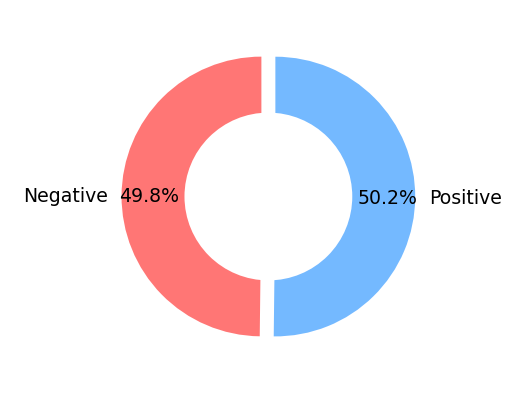

In [23]:
categoty_names = ['Negative', 'Positive']
sizes = [amount_of_negative_review, amount_of_positive_review]
custom_colours = ['#ff7675', '#74b9ff']
offset = [0.05, 0.05]

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=categoty_names, textprops={'fontsize': 6}, startangle=90,
       autopct='%1.1f%%', colors=custom_colours, pctdistance=0.8, explode=offset)

#draw a circle
centre_circle = plt.Circle((0, 0), radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)

plt.show()

### Word Cloud of Positive and Negative Reviews

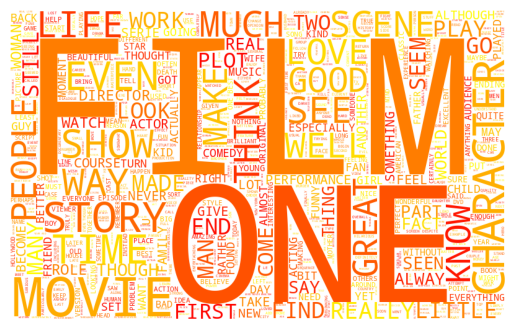

In [24]:
# Generate the text as a string for the Word Cloud
positive_str = ' '.join(list_positive)

wc = WordCloud(background_color='white', max_words=1000, colormap='autumn', width=800, height=500)
wc.generate(positive_str.upper())
plt.axis("off")
plt.imshow(wc)

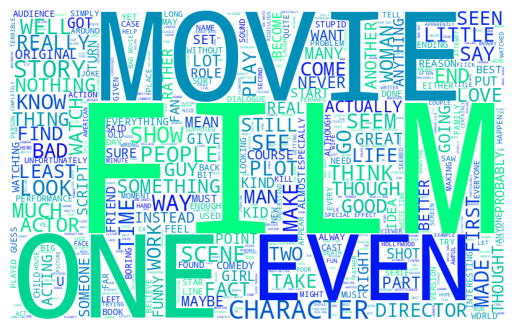

In [25]:
# Generate the text as a string for the Word Cloud
negative_str = ' '.join(list_negative)

wc = WordCloud(background_color='white', max_words=1000, colormap='winter', width=800, height=500)
wc.generate(negative_str.upper())
plt.axis("off")
plt.imshow(wc)

# Step 4: Feature Extraction

* Convert text data into numerical data

In [26]:
max_length = max(len(sublist) for sublist in nested_list)
print(max_length)

1394


In [27]:
df.reset_index()
df.head()

,review,sentiment,category
0,"[one, reviewer, mentioned, watching, oz, episo...",positive,1
1,"[wonderful, little, production, filming, techn...",positive,1
2,"[thought, wonderful, way, spend, time, hot, su...",positive,1
3,"[basically, family, little, boy, jake, think, ...",negative,0
4,"[petter, mattei, love, time, money, visually, ...",positive,1


In [28]:
df.shape

(49582, 3)

In [29]:
# Building a vocabulary
vocab = build_vocab_from_iterator(nested_list, specials=["<pad>", "<unk>"], min_freq=2)
vocab.set_default_index(vocab["<unk>"])

# Convert tokens to indices
def encode(text):
    return [vocab[token] for token in text]

encoded_data = [encode(text) for text in nested_list]

In [30]:
text_data = pad_sequence([torch.tensor(seq) for seq in encoded_data], batch_first=True, padding_value=vocab['<pad>'])
df['Encoded & Padded Text'] = text_data.tolist()
df.head()

,review,sentiment,category,Encoded & Padded Text
0,"[one, reviewer, mentioned, watching, oz, episo...",positive,1,"[4, 995, 905, 65, 2982, 166, 2858, 100, 477, 4..."
1,"[wonderful, little, production, filming, techn...",positive,1,"[276, 46, 228, 1186, 1548, 1311, 59, 11302, 40..."
2,"[thought, wonderful, way, spend, time, hot, su...",positive,1,"[90, 276, 26, 956, 6, 754, 1243, 2224, 1039, 7..."
3,"[basically, family, little, boy, jake, think, ...",negative,0,"[553, 117, 46, 195, 3026, 29, 501, 3532, 538, ..."
4,"[petter, mattei, love, time, money, visually, ...",positive,1,"[1, 9341, 34, 6, 188, 1933, 1211, 3, 33, 9341,..."


In [31]:
data_dict = {
    "Preprocessed Review": df['Encoded & Padded Text'].squeeze(),
    "Target": df['category'].squeeze()
}

df_prep = pd.DataFrame(data_dict)
df_prep.head()

,Preprocessed Review,Target
0,"[4, 995, 905, 65, 2982, 166, 2858, 100, 477, 4...",1
1,"[276, 46, 228, 1186, 1548, 1311, 59, 11302, 40...",1
2,"[90, 276, 26, 956, 6, 754, 1243, 2224, 1039, 7...",1
3,"[553, 117, 46, 195, 3026, 29, 501, 3532, 538, ...",0
4,"[1, 9341, 34, 6, 188, 1933, 1211, 3, 33, 9341,...",1


In [32]:
# count_vect = CountVectorizer(ngram_range=(1, 2))        
# transformer = TfidfTransformer(norm='l2',sublinear_tf=True)

# counts = count_vect.fit_transform(' '.join(df['review']))
# tfidf = transformer.fit_transform(counts)

In [33]:
a = ' '.join(df['review'][0])
a

'one reviewer mentioned watching oz episode hooked right exactly happened first thing struck oz brutality unflinching scene violence set right word go trust show faint hearted timid show pull punch regard drug sex violence hardcore classic use called oz nickname given oswald maximum security state penitentary focus mainly emerald city experimental section prison cell glass front face inwards privacy high agenda em city home muslim gangsta latino christian italian irish scuffle death stare dodgy dealing shady agreement never far would say main appeal show due fact go show would dare forget pretty picture painted mainstream audience forget charm forget romance oz mess around first episode ever saw struck nasty surreal could say ready watched developed taste oz got accustomed high level graphic violence violence injustice crooked guard sold nickel inmate kill order get away well mannered middle class inmate turned prison bitch due lack street skill prison experience watching oz may become